<a href="https://colab.research.google.com/github/suvankit/Speech-emotion-recognition/blob/main/SERipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# Dataset

In [ ]:
Crema="/content/gdrive/MyDrive/archive/Crema"
Ravdess="/content/gdrive/MyDrive/archive/Ravdess/audio_speech_actors_01-24/"
Savee="/content/gdrive/MyDrive/archive/Savee"
Tess="/content/gdrive/MyDrive/archive/Tess/"

1. Ravdess Dataframe

Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). 

NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...
1     calm  /content/gdrive/MyDrive/archive/Ravdess/audio_...
2      sad  /content/gdrive/MyDrive/archive/Ravdess/audio_...
3    happy  /content/gdrive/MyDrive/archive/Ravdess/audio_...
4    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...

2. Crema DataFrame

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Crema1079_WSI_...
1     fear  /content/gdrive/MyDrive/archive/Crema1080_IEO_...
2     fear  /content/gdrive/MyDrive/archive/Crema1079_TSI_...
3    happy  /content/gdrive/MyDrive/archive/Crema1079_TIE_...
4  disgust  /content/gdrive/MyDrive/archive/Crema1079_WSI_...

3. TESS dataset

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
1  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
2  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
3  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
4  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...

4. CREMA-D dataset

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:


'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                             Path
0    angry  /content/gdrive/MyDrive/archive/SaveeDC_a08.wav
1    angry  /content/gdrive/MyDrive/archive/SaveeDC_a07.wav
2    angry  /content/gdrive/MyDrive/archive/SaveeDC_a05.wav
3    angry  /content/gdrive/MyDrive/archive/SaveeDC_a09.wav
4    angry  /content/gdrive/MyDrive/archive/SaveeDC_a04.wav

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...
1     calm  /content/gdrive/MyDrive/archive/Ravdess/audio_...
2      sad  /content/gdrive/MyDrive/archive/Ravdess/audio_...
3    happy  /content/gdrive/MyDrive/archive/Ravdess/audio_...
4    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path1 = pd.concat([Ravdess_df, Tess_df], axis = 0)
data_path1.to_csv("data_path1.csv",index=False)
data_path1.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...
1     calm  /content/gdrive/MyDrive/archive/Ravdess/audio_...
2      sad  /content/gdrive/MyDrive/archive/Ravdess/audio_...
3    happy  /content/gdrive/MyDrive/archive/Ravdess/audio_...
4    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...

In [ ]:
data_path2 = pd.concat([Crema_df], axis = 0)
data_path2.to_csv("data_path2.csv",index=False)
data_path2.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Crema1079_WSI_...
1     fear  /content/gdrive/MyDrive/archive/Crema1080_IEO_...
2     fear  /content/gdrive/MyDrive/archive/Crema1079_TSI_...
3    happy  /content/gdrive/MyDrive/archive/Crema1079_TIE_...
4  disgust  /content/gdrive/MyDrive/archive/Crema1079_WSI_...

In [ ]:
data_path3 = pd.concat([Tess_df], axis = 0)
data_path3.to_csv("data_path3.csv",index=False)
data_path3.head()

Emotions                                               Path
0  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
1  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
2  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
3  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...
4  surprise  /content/gdrive/MyDrive/archive/Tess/YAF_pleas...

In [ ]:
data_path4 = pd.concat([Ravdess_df], axis = 0)
data_path4.to_csv("data_path4.csv",index=False)
data_path4.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...
1     calm  /content/gdrive/MyDrive/archive/Ravdess/audio_...
2      sad  /content/gdrive/MyDrive/archive/Ravdess/audio_...
3    happy  /content/gdrive/MyDrive/archive/Ravdess/audio_...
4    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...

# Data Visualisation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


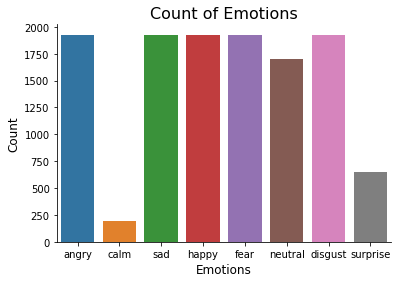

In [ ]:
#count of each emotions
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Waveplots - Waveplots let us know the loudness of the audio at a given time.

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

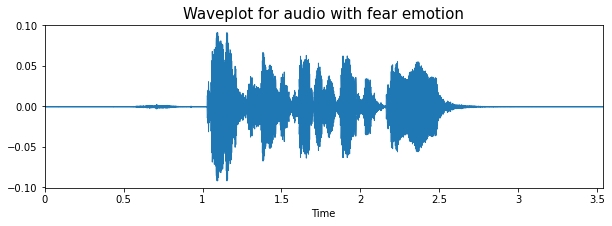

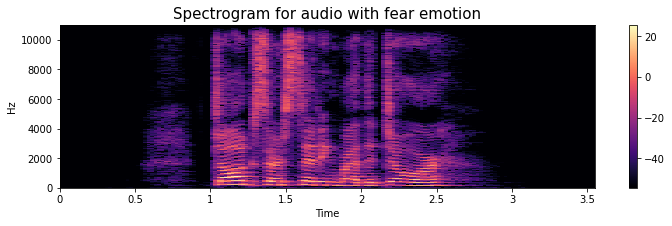

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

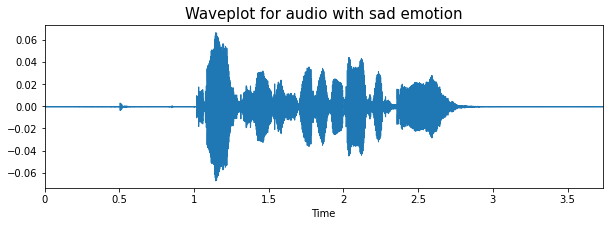

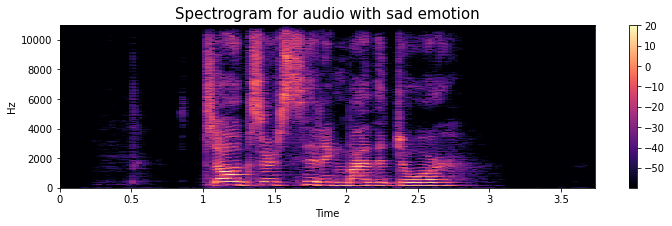

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

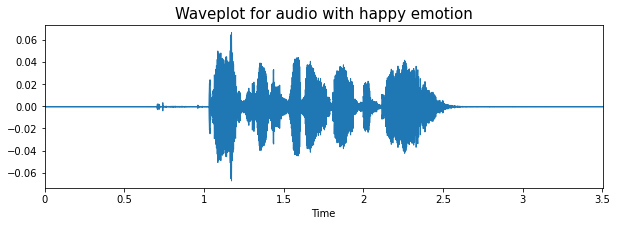

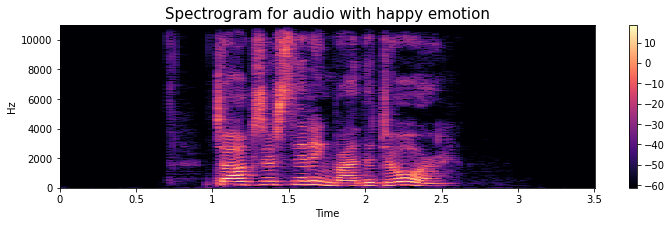

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

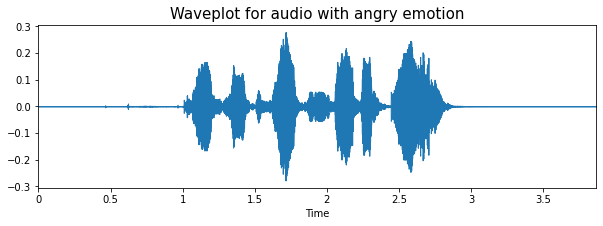

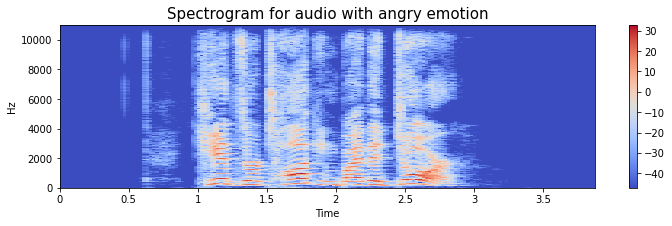

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

The objective is to make our model invariant to those perturbations and enhace its ability to generalize.

In order to this to work adding the perturbations must conserve the same label as the original training sample.

In images data augmention can be performed by shifting the image, zooming, rotating ...

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

1. Simple Audio

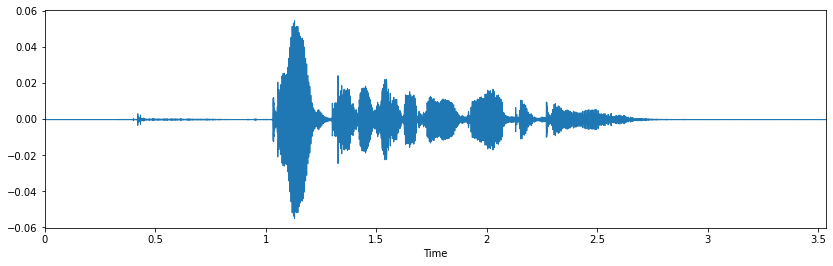

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

2. Noise Injection

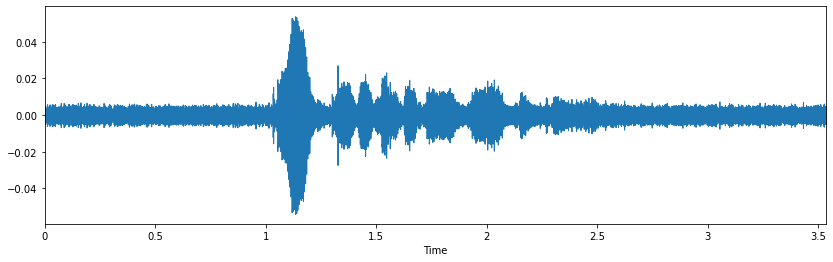

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

3.Streching

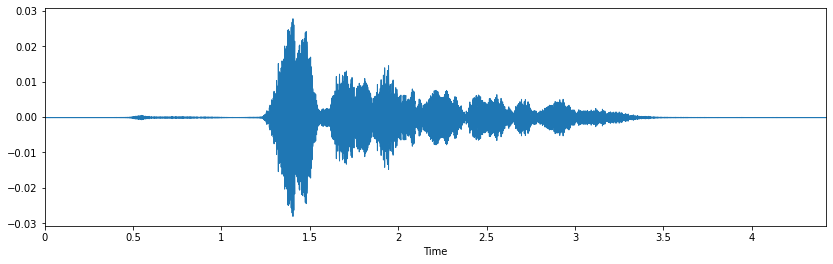

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

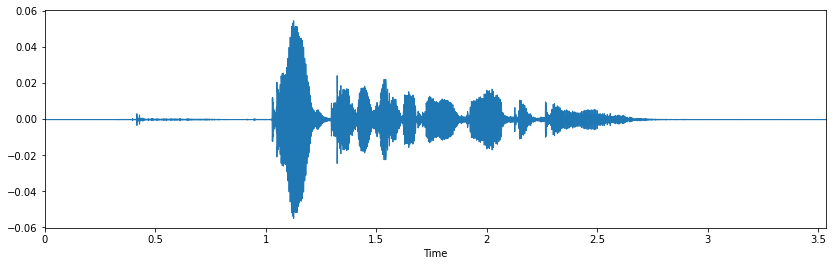

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

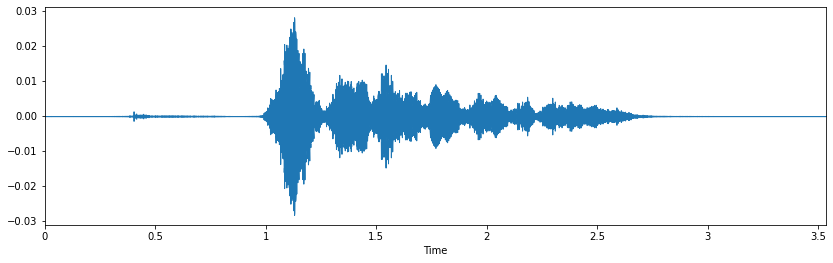

In [ ]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.



In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    # result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path4.Path, data_path4.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(686880, 686880, (12169,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features2.csv', index=False)
Features.head()

0 labels
0  0.177047  angry
1  0.517131  angry
2  0.555209  angry
3  0.556943  angry
4  0.554097  angry

# Data Preparation
As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
import pandas as pd
Features = pd.read_csv('/content/sample_data/features.csv')
Features.head()

0 labels
0  0.177047  angry
1  0.517131  angry
2  0.555209  angry
3  0.556943  angry
4  0.554097  angry

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
#the label encoder function
label_encode = preprocessing.LabelEncoder() 
  
# Encode labels in column 'labels'. 

y= label_encode.fit_transform(Features['labels']) 
  
#y.unique() 
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((515160, 1), (515160, 8), (171720, 1), (171720, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((515160, 1), (515160, 8), (171720, 1), (171720, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 256)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
8050/8050 [==============================] - 606s 75ms/step - loss: 2.0373 - accuracy: 0.1491 - val_loss: 2.0336 - val_accuracy: 0.1543 - lr: 0.0010
Epoch 2/50
8050/8050 [==============================] - 606s 75ms/step - loss: 2.0304 - accuracy: 0.1575 - val_loss: 2.0264 - val_accuracy: 0.1589 - lr: 0.0010
Epoch 3/50
8050/8050 [==============================] - 604s 75ms/step - loss: 2.0284 - accuracy: 0.1603 - val_loss: 2.0281 - val_accuracy: 0.1589 - lr: 0.0010
Epoch 4/50
8050/8050 [==============================] - 601s 75ms/step - loss: 2.0284 - accuracy: 0.1605 - val_loss: 2.0249 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 5/50
8050/8050 [==============================] - 597s 74ms/step - loss: 2.0265 - accuracy: 0.1619 - val_loss: 2.0222 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/50
8050/8050 [==============================] - 602s 75ms/step - loss: 2.0261 - accuracy: 0.1629 - val_loss: 2.0156 - val_accuracy: 0.1749 - lr: 0.0010
Epoch 7/50
8050/8050 [==================

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

logreg = LogisticRegression()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
svc = SVC()
nb = BernoulliNB()
et = ExtraTreesClassifier()
rf = RandomForestClassifier()
dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes',5:'Extra Tree',6:'Random Forest'}
models=[logreg,dt ,knn ,svc ,nb ,et ,rf ]

In [ ]:
from sklearn.model_selection import cross_val_score
for i,model in enumerate(models):
  print("{}--> Mean Accuracy--> {}".format(dict[i],cross_val_score(model,X,y,cv=15,scoring='accuracy').mean()))

Logistic Regression--> Mean Accuracy--> 0.1390927090612625
Decision Tree--> Mean Accuracy--> 0.163022653156301
KNN--> Mean Accuracy--> 0.15104967388772422
